# Importing and cleaning data

In [33]:
# Importing the usual stuff

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline
import os, time
from random import sample

pd.set_option('display.max_columns', None)

In [2]:
# Creating the dataframe df_shelv in order to filter out the shelving locations later on

df_shelv = pd.read_excel('shelving.xlsx')
df_shelv.rename(columns={'Location':'DSP_LOCN','Unnamed: 1':'Shelving'},inplace=True)
df_shelv.head()

,DSP_LOCN,Shelving
0,4S00010101,SHELVING
1,4S00010102,SHELVING
2,4S00010103,SHELVING
3,4S00010104,SHELVING
4,4S00010105,SHELVING


In [3]:
# Creating the dataframe df_S_NS to have the saleable and non-saleable product.
# It will be useful for filtering out the NS product later on.

df_S_NS = pd.read_csv('exportFG_FOC.csv')
df_S_NS.head()

,ITEM_NAME,SALE_GRP
0,S1442800,S
1,S1442801,S
2,S1532600,S
3,S1663800,S
4,S1663801,S


In [4]:
# Reading all the snapshots inventory and creating the dictionnary d_init to store them

path = "C:\\Users\\btg168\\Desktop\\Inventory reports test\\"
d_init={}

for file in os.listdir(path):
    d_init[file] = pd.read_excel(path+file)
    d_init[file]['Date File created'] = time.ctime(os.path.getmtime(path+file))
    d_init[file]['Date File created'] = pd.to_datetime(d_init[file]['Date File created'])
    d_init[file]['Date File created'] = d_init[file]['Date File created'].dt.date


In [10]:
# Concatenating all the dataframes from the dictionnary into one big dataframe called df_concat_raw

df_concat_raw = pd.concat(d_init.values())
df_concat_raw['DSP_LOCN'] = df_concat_raw['DSP_LOCN'].astype(str)

In [11]:
# Taking a look at the columns types

df_concat_raw.dtypes

COMPANY_NAME          object
WHSE                  object
LPN_STATUS            object
REF_FIELD1            object
MERCH_TYPE            object
CODE_DESC             object
TC_LPN_ID             object
DSP_LOCN              object
EAN                    int64
ITEM_NAME             object
ZINDEX                 int64
DESCRIPTION           object
INVENTORY_TYPE        object
ON_HAND_QTY            int64
WM_ALLOCATED_QTY       int64
AVAILABLE_QTY          int64
BATCH_NBR             object
MANUFACTURED_DTTM     object
RECEIVED_DTTM         object
EXPIRATION_DATE       object
STOCK_AGE_DAYS       float64
AGEING_DAYS          float64
PROD_LIFE_IN_DAY     float64
LAST_UPDATED_DTTM     object
STD_PACK_QTY           int64
TC_ASN_ID             object
Date File created     object
dtype: object

In [7]:
# Taking a look at its shape

df_concat_raw.shape

(1969220, 27)

In [38]:
# Defining a function to check the locations not to be taken into account (the ones with more than 1 letter)

def check_locn():
    list1 = []
    list2 = []
    for i in df_concat_raw['DSP_LOCN']:
        if len(list1) < 1000 and len(list2) < 1000:
            if len(i)-sum(c.isdigit() for c in i) == 2:
                list1.append(i)
            elif len(i)-sum(c.isdigit() for c in i) > 2 and i != 'nan':
                list2.append(i)
    return sample(list1,10), sample(list2,10)

In [39]:
# Checking the locations not to be taken into account

check_locn()

(['LT00002349',
  'LT00001285',
  'LT00002729',
  'LT00001115',
  'LT00000103',
  'LT00001602',
  'LT00002287',
  'LT00001227',
  'LT00000106',
  'LT00001284'],
 ['ROBOTICARM',
  '4STAGE0430',
  '4STAGE0014',
  'ROBOTICARM',
  'ROBOTICARM',
  '4STAGE0371',
  'ROBOTICARM',
  '4STAGE0462',
  'ROBOTICARM',
  '4STAGE0124'])

In [14]:
# Cleaning the dataframe

df_concat_filtered = df_concat_raw.merge(df_shelv,on='DSP_LOCN',how='left')
df_concat_filtered = df_concat_filtered.merge(df_S_NS,on='ITEM_NAME',how='left' )
df_concat_filtered.dropna(subset=['DSP_LOCN'],inplace=True)
# Regrouping small brands into the group 'Mixed Brands'
df_concat_filtered[['REF_FIELD1']] = df_concat_filtered['REF_FIELD1'].replace(to_replace=\
                                                                          ['HR','R. LAUREN','URBAN DECAY','KERASTASE',\
                                                                           'SKINCEUTICALS','Martin MARGIELA','VICHY',\
                                                                           'Atelier Cologne','VIKTOR ET ROLF',\
                                                                           'ROCHE POSAY','HOUSE 99',\
                                                                           'IMARQUES INTER-DEPARTMENT','CLARISONIC']\
                                                                          ,value = 'Mixed Brands')
# Creating a new column to spot locations that have more than 1 letter like '6STAGE0404', '4COPACKR01', or 'LT00002524'
df_concat_filtered['to keep'] = df_concat_filtered['DSP_LOCN'].apply(lambda x: False if len(x)-sum(c.isdigit() for c in x)>1 else True)
# Filtering the locations that are in the racks
df_concat_filtered = df_concat_filtered.loc[(df_concat_filtered['INVENTORY_TYPE']=='U') \
                                            & (df_concat_filtered['ZINDEX']==1)\
                                            & (df_concat_filtered['Shelving'].isna()) & (df_concat_filtered['to keep']== True)\
                                            & (df_concat_filtered.DSP_LOCN.str[:1] == '4')\
                                            & (df_concat_filtered['REF_FIELD1'] != "L'OREAL PARIS")]
df_concat_filtered = df_concat_filtered[['REF_FIELD1','DSP_LOCN','ITEM_NAME','SALE_GRP','Date File created']]
df_concat_filtered = df_concat_filtered.reset_index(drop=True)

In [15]:
# Taking a look at our final dataframe

df_concat_filtered.head()

,REF_FIELD1,DSP_LOCN,ITEM_NAME,SALE_GRP,Date File created
0,YSL,4P10251601,TS855900,NS,2020-04-19
1,LANCOME,4P24281601,TS788300,NS,2020-04-19
2,YSL,4P08241002,F7018900,S,2020-04-19
3,LANCOME,4P17130102,TM718303,S,2020-04-19
4,BIOTHERM,4P13181202,LA373701,NS,2020-04-19


# Evolution of brands' ratio occupancy over the time

In [26]:
# Creating the master file that regroups each brand max occupancy

df_master = pd.DataFrame({'REF_FIELD1':['Mixed Brands','BIOTHERM','SHU UEMURA','YSL','G. ARMANI','KIEHLS',\
                                   'LANCOME'],'Max Occupancy':[1540,1491,1190,2156,1652,3948,5087]})

In [27]:
# Taking a look at the master dataframe

df_master

,REF_FIELD1,Max Occupancy
0,Mixed Brands,1540
1,BIOTHERM,1491
2,SHU UEMURA,1190
3,YSL,2156
4,G. ARMANI,1652
5,KIEHLS,3948
6,LANCOME,5087


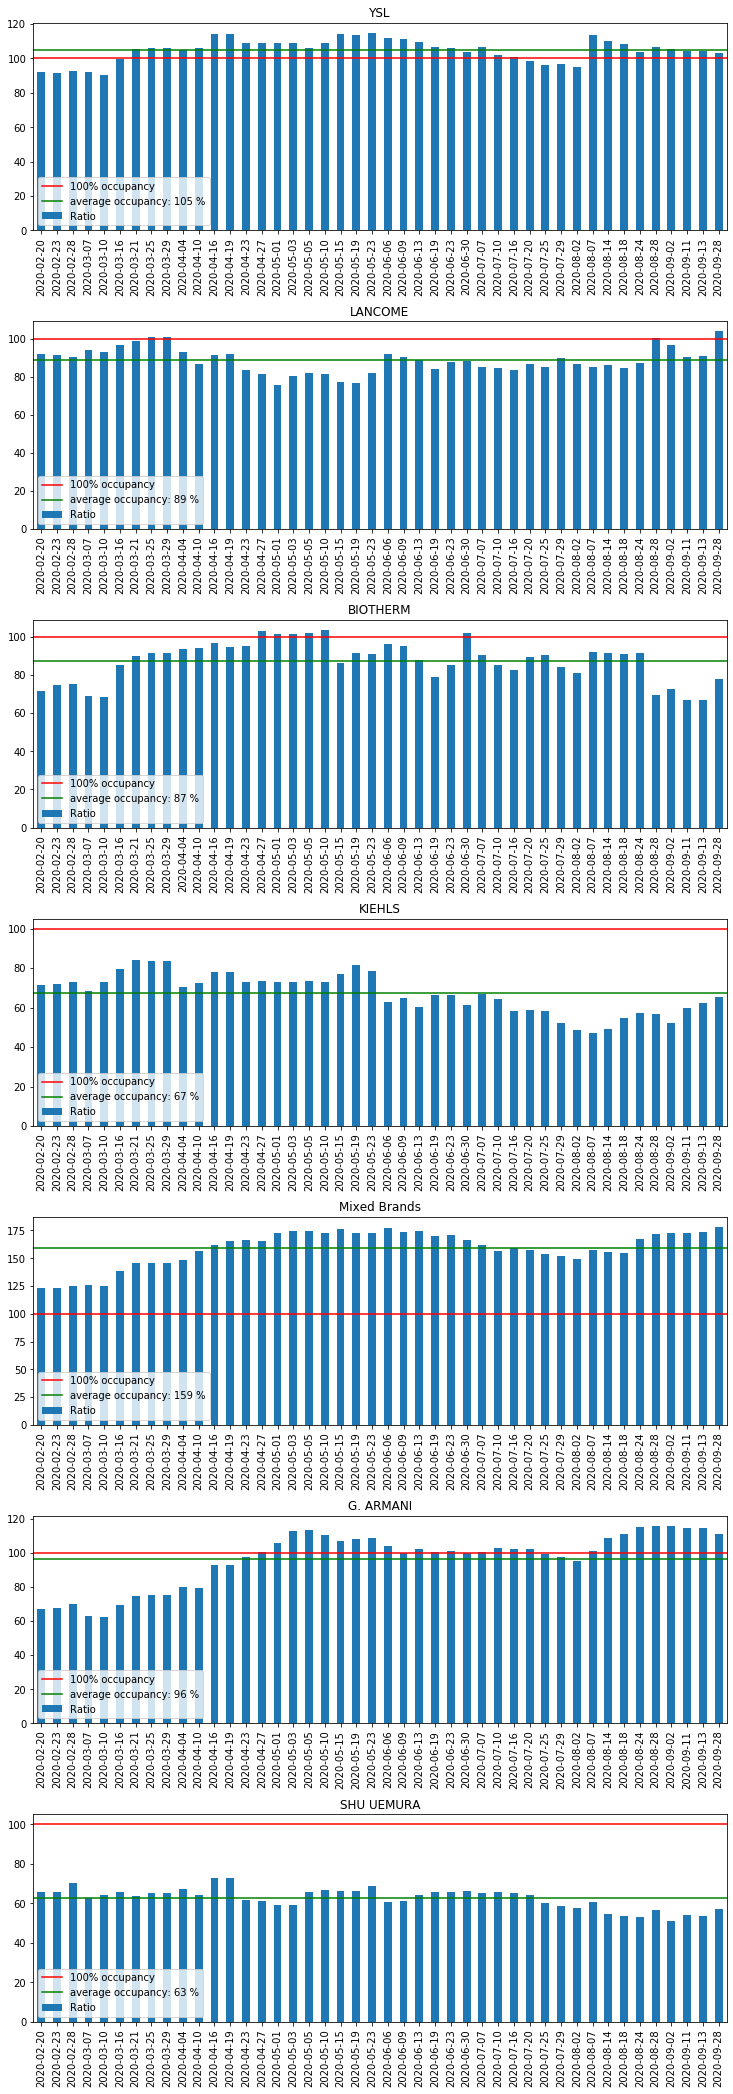

In [28]:
# Displaying each brand plot

fig, axes = plt.subplots(len(df_concat_filtered['REF_FIELD1'].unique()), figsize = (12,30))
fig.tight_layout(pad = 7.0)
i = 0

for ref in list(df_concat_filtered['REF_FIELD1'].unique()):
    df_plot = df_concat_filtered[df_concat_filtered['REF_FIELD1'] == f'{ref}'\
                                ].groupby(['REF_FIELD1','Date File created'])[['DSP_LOCN']].nunique().reset_index()
    df_plot = df_plot.merge(df_master, on='REF_FIELD1', how='left')
    df_plot['Ratio'] = df_plot.apply(lambda x: x['DSP_LOCN']*100/x['Max Occupancy'], axis = 1)
    df_plot = df_plot[['REF_FIELD1','Ratio','Date File created']]
    df_plot.plot(kind = 'bar', ax = axes[i], x = 'Date File created')
    axes[i].set_xlabel('')
    axes[i].axhline(y = 100, color = 'r',label = '100% occupancy')
    axes[i].axhline(y = df_plot['Ratio'].mean()\
                    , color ='g',label = f"average occupancy: {round(df_plot['Ratio'].mean())} %")
    axes[i].legend(loc = 'lower left')
    axes[i].set_title(f"{ref}")
    
    i += 1
    